In [1]:
import numpy as np
import random
import math
import time
import os
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from d2l import torch as d2l
d2l.use_svg_display()
from torch.utils.data import Dataset,TensorDataset,DataLoader,random_split

3.941700786896856e-07
3.941453491286863e-07
3.942276657349615e-07
3.9428216659360723e-07


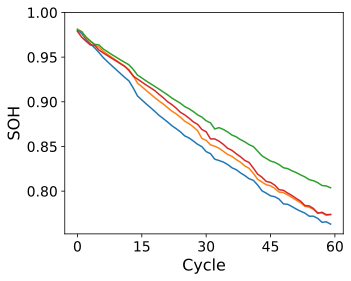

In [2]:
Battery_list = ['Cell1','Cell3','Cell7','Cell8' ]
data_root='../data/OXFORD_data/all_path/'
def smooth_data(sequence, window_size):
    """数据平滑"""
    if window_size < 1:
        raise ValueError("窗口大小必须大于等于1")
    # 初始化平滑后的数据列表
    smoothed_sequence = []
    # 计算窗口内的平均值
    for i in range(len(sequence)):
        # 计算窗口的起始和结束索引
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        # 计算窗口内的数据平均值
        window_average = sum(sequence[start_index:end_index]) / (end_index - start_index)
        # 将平均值添加到平滑后的数据列表中
        smoothed_sequence.append(window_average)
    return smoothed_sequence
def drop_outlier(array,count,bins):
    """离群值提取--用3sigma方法"""
    index = []
    range_n = np.arange(1,count,bins)
    for i in range_n[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)
def clean_data(array_figs,array_labels):
    index_keep=drop_outlier(array_labels,len(array_labels),35)
    array_figs,array_labels=array_figs[index_keep],array_labels[index_keep]
    array_figs,array_labels=array_figs[drop_outlier(array_labels,len(array_labels),10)],array_labels[drop_outlier(array_labels,len(array_labels),10)]
    return array_figs,array_labels
def add_row_index_to_array(arr):
    """
    在输入数组的每一行的第一个元素加上行号，并扩展数组维度。
    
    参数:
    arr (np.ndarray): 形状为 (n, 6) 的输入数组。
    
    返回:
    np.ndarray: 形状为 (n, 7) 的数组。
    """
    # 检查输入数组形状是否为 (n, 6)
    if arr.shape[1] != 10:
        raise ValueError("输入数组必须是形状为 (n, 6) 的数组。")

    # 创建一个新数组，其形状为 (n, 7)，初始化为输入数组
    new_arr = np.zeros((arr.shape[0], 11))
    new_arr[:, 1:] = arr  # 将输入数组的数据复制到新数组的后面六个列
    # 在新数组的每一行的第一个元素加上行号
    new_arr[:, 0] = np.arange(arr.shape[0])
    return new_arr
plt.figure(figsize=(5, 4))
for name in Battery_list:
    path=data_root+name+'.npz'
    arrays=np.load(path)
    features,SOHs=clean_data(arrays['array1'],arrays['array2'])
    plt.plot(SOHs)
    # """抛弃异常值处理"""
    # index_keep=drop_outlier(SOHs,len(SOHs),35)
    # plt.plot(SOHs[index_keep][drop_outlier(SOHs[index_keep],len(SOHs[index_keep]),10)])
    # plt.plot(process_sequence(SOHs,1))
    plt.yticks([0.8,0.85,0.9,0.95,1],fontsize=14)
    plt.xticks([0,15,30,45,60],fontsize=14)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('SOH',fontsize=16)
    print(features[1][0])
plt.show()

In [3]:
def setup_seed(seed):
    """set random seed"""
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
def get_data():
    """获取训练集，测试集，验证集"""
    train_list = Battery_list
    train_data=[]
    for b_n in train_list:
        path = '../data/OXFORD_data/all_path/' + b_n + '.npz'
        arrays = np.load(path)
        a,b=clean_data(arrays['array1'],arrays['array2'])
        a=add_row_index_to_array(a)
        train_data.append([a,b])
    train_valid_features=torch.from_numpy(np.concatenate((train_data[0][0],train_data[2][0]),axis=0)).float()
    train_valid_labels=torch.from_numpy(np.concatenate((train_data[0][1],train_data[2][1]),axis=0)).float()
    dataset=TensorDataset(train_valid_features,train_valid_labels)
    # 确定训练集和验证集的大小
    train_size = int(0.2 * len(dataset))  # 80%的训练集
    val_size = len(dataset) - train_size   # 剩余的20%作为验证集
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_7_data,test_8_data=[train_data[1][0],train_data[1][1]],[train_data[3][0],train_data[3][1]]
    return train_loader, val_loader, test_7_data,test_8_data

a,b,_,_,=get_data()
for x,y in b:
    print(x.shape)

torch.Size([16, 11])
torch.Size([16, 11])
torch.Size([16, 11])
torch.Size([16, 11])
torch.Size([16, 11])
torch.Size([16, 11])


In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0):
        """用多头注意力进行解码"""
        """
        多头注意力模块。
        :param input_dim: 输入特征维度
        :param output_dim: 输出特征维度
        :param num_heads: 注意力头的数量
        :param head_dim: 每个注意力头的维度
        :param dropout: Dropout 概率
        """
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim-1
        self.output_dim = output_dim-1
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        # 线性变换层，将输入映射到 Q, K, V
        self.query = nn.Linear(input_dim-1, num_heads * head_dim)
        self.key = nn.Linear(input_dim-1, num_heads * head_dim)
        self.value = nn.Linear(input_dim-1, num_heads * head_dim)
        # 输出线性层
        self.fc_out = nn.Linear(num_heads * head_dim, output_dim-1)
        # Dropout 层
        self.dropout_layer = nn.Dropout(dropout)
    def forward(self, x):
        """
        前向传播。
        :param x: 输入张量，形状为 (batch_size, input_dim)
        :return: 输出张量，形状为 (batch_size, output_dim)
        """
        batch_size = x.size(0)
        x_t=x[:,0].unsqueeze(1)
        x=x[:,1:]
        # 线性变换，得到 Q, K, V
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_heads, seq_len, head_dim)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = self.dropout_layer(attention_weights)
        # 计算加权和
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len, head_dim)
        # 拼接多头输出
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)  # (batch_size, seq_len, num_heads * head_dim)
        # 通过线性层映射到输出维度
        output = self.fc_out(attention_output)  # (batch_size, seq_len, output_dim)
        output=torch.cat((x_t,output.squeeze(1)),dim=-1)
        return output  # (batch_size, output_dim)
"""--------------------------------------------------------多物理场混合专家模型-------------------------------------------------------"""
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, num_experts, expert_hidden_dim):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # 专家网络
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(2*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,64*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(64*expert_hidden_dim,32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim,expert_hidden_dim ),
            )
            for _ in range(num_experts)
        ])
        # 门控网络
        self.gating_network = nn.Linear(input_dim, num_experts)
        # 输出层
        self.output_layer = nn.Linear(expert_hidden_dim, 1)
    def initialize_weights(self):
        nn.init.xavier_uniform_(self.gating_network.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    def forward(self, x):
        # 计算所有专家的输出
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        #shape(batch_size,num_expert,expert_hidden_dim)
        # 计算门控网络的输出并应用softmax得到权重
        gate_works=torch.exp(self.gating_network(x)/10)
        gating_outputs = F.softmax(gate_works, dim=1)
        # 将门控网络的输出（权重）与专家网络的输出相乘并求和
        combined_output = torch.sum(expert_outputs * gating_outputs.unsqueeze(-1), dim=1)
        # 通过输出层得到最终输出
        final_output = self.output_layer(combined_output)
        return final_output,expert_outputs      #返回总输出和每个专家输出
    
class PINN_MOE(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=3,expert_hidden_dim=2):
        super(PINN_MOE, self).__init__()
        self.Decoupling=MultiHeadAttention(input_dim, output_dim, num_heads, head_dim, dropout)
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
        self.physics=nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        # self.electricity=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.heat=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.mechine=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.parameter_heat=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity1=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity2=nn.Parameter(torch.tensor(1, dtype=torch.float32))
    def  initialize_weights(self):
        nn.init.xavier_uniform_(self.Decoupling.parameters)
        nn.init.xavier_uniform_(self.multi_physics.parameters)
        # nn.init.xavier_uniform_(self.heat.parameters)
        # nn.init.xavier_uniform_(self.mechine.parameters)
        # nn.init.xavier_uniform_(self.electricity.parameters)
        nn.init.xavier_uniform_(self.physics.parameters)
        nn.init.xavier_uniform_(self.parameter_heat)
        nn.init.xavier_uniform_(self.parameter_electricity1)
        nn.init.xavier_uniform_(self.parameter_electricity2)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        # 计算 s_pred 对 t 和 x 的偏导数
        """综合损失"""
        s_t = grad(s_pred.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        s_x = grad(s_pred.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        """热效应损失"""
        T_Q=experts[:,0:1,:].squeeze(1)
        # print(T_Q.shape)
        T=T_Q[:,0:1]
        Q=T_Q[:,1:2]
        T_t=grad(T.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_x=grad(T.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_laplace=grad(T_t.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_heat=torch.mean((T_t - (self.parameter_heat) * T_laplace - Q) ** 2, dim=1).unsqueeze(1)
        """电化学效应损失"""
        phi_c=experts[:,1:2,:].squeeze(1)
        phi=phi_c[:,0:1]
        c=phi_c[:,1:2]
        phi_t=grad(phi.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_x=grad(phi.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_x=grad(c.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_t=grad(c.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_laplace=grad(phi_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_laplace=grad(c_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_electricity=torch.mean((c_t -self.parameter_electricity1 * c_laplace -self.parameter_electricity2) ** 2,dim=1).unsqueeze(1)+torch.mean(phi_laplace** 2,dim=1).unsqueeze(1)
        """机械应力损失"""
        sigma_f=experts[:,2:3,:].squeeze(1)
        sigma=sigma_f[:,0:1]
        f=sigma_f[:,1:2]
        sigma_x=grad(sigma.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        sigma_laplace=grad(sigma_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_mechine=torch.mean((sigma_laplace + f) ** 2,dim=1).unsqueeze(1)
        # 打印 s_t 和 s_x，确保它们不为 None
        # 计算物理约束 F
        F_input = torch.cat([phi,c,T,Q,sigma,f], dim=1)
        soh = self.physics(F_input)
        # 计算残差 f
        loss_all = 0.01*loss_electricity+0.01*loss_heat+0.01*loss_mechine
        return soh, loss_all,[phi,c,T,Q,sigma,f]
        
        

In [14]:
def train(lr=0.003,epochs=200, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data=get_data()
    test_data=[test_35_data, test_36_data]
    model = PINN_MOE()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    lists=[]
    """早停止获取最佳模型"""
    val_mse=10
    train_loss=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred,f,_= model(X)
            f_target = torch.zeros_like(f)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)+0.3*criterion(f,f_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
            train_loss=loss_epoch/len_dataloader
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre,_,_=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<1e-4 and train_loss<2e-4)or (epoch+1)==epochs:
            model=model.cpu()
            torch.save(model.state_dict(), '../pretrained/ox_model.pth')
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred,_,list=model(X)
                for i in range(len(list)):
                    list[i]=list[i].detach().cpu().numpy()
                lists.append(list)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results,lists
        

## 五个随机种子训练

In [15]:
tests=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result,_=train(seed=i,device=device)
    tests.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0999, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0110, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0061, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0037, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0044, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0030, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [16]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae
def mape(sequence_true, sequence_pred):
    """
    计算两个序列的MAPE（Mean Absolute Percentage Error）

    参数:
    sequence_true: 实际值序列
    sequence_pred: 预测值序列

    返回:
    mape: 平均绝对百分比误差
    """
    if len(sequence_true) != len(sequence_pred):
        raise ValueError("两个序列的长度必须相同")

    # 计算绝对百分比误差
    ape = [abs((true - pred) / true) for true, pred in zip(sequence_true, sequence_pred) if true != 0]

    # 计算平均绝对百分比误差
    mape = sum(ape) / len(ape)

    return mape

# 示例使用
sequence_true = [100, 200, 300, 400, 500]
sequence_pred = [90, 210, 310, 380, 480]
print("MAPE:", mape(sequence_true, sequence_pred))
def r_squared(y_true, y_pred):
    """
    计算两个序列的R方（R-squared）

    参数:
    y_true: 实际值序列
    y_pred: 预测值序列

    返回:
    r2: R方值
    """
    # 计算实际值的平均值
    y_mean = sum(y_true) / len(y_true)
    
    # 计算总平方和（Total Sum of Squares, TSS）
    ss_total = sum((y_true - y_mean) ** 2)
    
    # 计算回归平方和（Regression Sum of Squares, RSS）
    ss_residual = sum((y_true - y_pred) ** 2)
    
    # 计算R方
    r2 = 1 - (ss_residual / ss_total)
    
    return r2

MAPE: 0.05466666666666666


In [17]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests[i][j][0],tests[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)
np.mean(rmse_all)

RMSE: [0.00639311173980771, 0.010140318800338343, 0.009226523536653423, 0.00678208942436708, 0.012409485191017098, 0.011489778554024294, 0.019660451276952488, 0.014437892829010408, 0.014348897755762015, 0.010951772818716905]
MAE: [0.005458544375583598, 0.00977578557918178, 0.008070981568046984, 0.005847894639932116, 0.0107180517921206, 0.010022249001218612, 0.01663882129846622, 0.011725844096977205, 0.011296332995804216, 0.007769081599204863]
MAPE: [0.006371002554267031, 0.011253732659287584, 0.009707745729271045, 0.006787435521839938, 0.012772184833333448, 0.01145872413334198, 0.020195932711077884, 0.014184661821098737, 0.013806328619666686, 0.009554995268358464]
R2: [0.9899746363292262, 0.9738090577504865, 0.9791189788522219, 0.9882841196244917, 0.9622268611099508, 0.9663743086694992, 0.9051881742406473, 0.9469047668021658, 0.9494975290718813, 0.9694496100743889]


0.011584032192664975

## 测试

In [18]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests)):
#     for j in range(len(tests[0])):
#         real,pred=tests[i][j][0],tests[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_results,lists=train(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0999, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0110, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0061, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0037, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0044, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0030, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [20]:
reals=[]
preds=[]
for i in range(2):
    real,pred=test_results[i][0],test_results[i][1]
    reals.append(real)
    preds.append(pred)
reals=np.concatenate(reals,axis=0)
preds=np.concatenate(preds,axis=0).squeeze()
path='D:/Pywork/CNN_ATTENTION_PINN/new/results/preds/oxford.npz'
np.savez(path,reals=reals,preds=preds)

In [12]:
for i in range(2):
    real,pred=test_results[i][0],test_results[i][1]
    rmse=evaluation(real,pred)
    print(rmse)

0.003178889350747312
0.004840268991179267


In [38]:
class MLP(nn.Module):
    def __init__(self, input_size=11, output_size=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.Linear(256, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, output_size))
    def forward(self, x):
        return self.net(x)
def train_mlp(lr=0.001,epochs=200, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data=get_data()
    test_data=[test_35_data, test_36_data]
    model = MLP()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<1e-3 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [39]:
tests_mlp=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_mlp(seed=i,device=device)
    tests_mlp.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0196, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0200, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0017, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0021, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(4.9142e-05, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(3.3482e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(5.7159e-05, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss

In [40]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.008991170408072851, 0.01766493912486361, 0.004583073364168269, 0.007757996135642946, 0.004861698732298804, 0.004836793722544175, 0.004071081666177794, 0.011714347230648885, 0.004461215758343867, 0.01216904675050802]
MAE: [0.008742572743980024, 0.017507835996674236, 0.004056590014003234, 0.00646895333320322, 0.004270415624690121, 0.004371964427571262, 0.003005397251574754, 0.011083543938303216, 0.003639019877553845, 0.011441148094859459]
MAPE: [0.010113943872596298, 0.020143793198654426, 0.004826546359123158, 0.007149194509916852, 0.00489622395568705, 0.00507872163733619, 0.003423484751265806, 0.012594950962043232, 0.004038821274766168, 0.01290075869468687]
R2: [0.980170671705786, 0.9205173761638014, 0.9948478421067473, 0.9846698281625541, 0.9942023548342607, 0.9940411419842905, 0.9959346759036753, 0.9650470294473481, 0.9951181773225035, 0.962280925837045]


In [27]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests_mlp)):
#     for j in range(len(tests_mlp[0])):
#         real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

RMSE: [0.02895238818411297]
MAE: [0.02083116]


## 挑出来一组画图

In [36]:
test_results_mlp=train_mlp(seed=1,device=device)

training seed 1:

Epoch: 5 Train_RMSELoss: tensor(0.0638, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0575, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0020, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0007, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0002, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0002, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0002, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [37]:
for i in range(2):
    real,pred=test_results_mlp[i][0],test_results_mlp[i][1]
    rmse=evaluation(real,pred)
    print(rmse)

0.01198461710176137
0.014795532963108166


In [12]:
class ConvNet(nn.Module):
    def __init__(self, n_input=7):
        super(ConvNet, self).__init__()
        # 输入重塑为 (batch, 1, n_input)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * (n_input // 2), 64)  # 根据池化后的维度调整
        self.fc2 = nn.Sequential(nn.Linear(64 , 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 1),)
    
    def forward(self, x):
        # 输入 x 的形状: (batch, n_input)
        x = x.unsqueeze(1)  # 重塑为 (batch, 1, n_input)
        x = self.conv1(x)   # 卷积后形状: (batch, 32, n_input)
        x = self.relu(x)
        x = self.pool(x)    # 池化后形状: (batch, 32, n_input // 2)
        x = x.view(x.size(0), -1)  # 展平为 (batch, 32 * (n_input // 2))
        x = self.fc1(x)     # 全连接层
        x = self.relu(x)
        x = self.fc2(x)     # 输出形状: (batch, 1)
        return x
def train_conv(lr=0.001,epochs=200, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data=get_data()
    test_data=[test_35_data, test_36_data]
    model = ConvNet()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<0.5e-4 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



## 随机种子训练

In [13]:
tests_cnn=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_conv(seed=i,device=device)
    tests_cnn.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.2231, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.2034, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.1293, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.1216, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0328, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0239, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0094, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0048, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0005, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [14]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.011600966343075829, 0.01333761446568974, 0.011688967409281792, 0.012172916065271596, 0.006712285418087572, 0.007107526559662006, 0.029927734145233056, 0.029887869378110443, 0.008129234554148651, 0.010342726204122304]
MAE: [0.009337374951525245, 0.01170642285335625, 0.009526621279143012, 0.010782874568239391, 0.004721763629777281, 0.005086625477819299, 0.02301761004784315, 0.021454499185448412, 0.006348100412984231, 0.008681617888934645]
MAPE: [0.011007708063791794, 0.013592152516819712, 0.011433177192054639, 0.012655125096394909, 0.005607731310376693, 0.006066102528760898, 0.02686138436376457, 0.02512005929751953, 0.007476558792134069, 0.010008220456672922]
R2: [0.9669886048679445, 0.9546889397684841, 0.966485878421287, 0.9622569354331232, 0.9889486234776805, 0.9871327752268996, 0.7803034586955213, 0.7724704446559837, 0.9837903045882608, 0.9727530458348813]


In [20]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size=7, hidden_size=60, num_layers=6, output_size=1):
        """
        LSTM网络初始化
        :param input_size: 输入特征的维度 (n)
        :param hidden_size: 隐藏层的维度
        :param num_layers: LSTM的层数
        :param output_size: 输出的维度 (1)
        """
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 定义全连接层，将LSTM的输出映射到输出维度
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据，形状为 (batch_size, input_size)
        :return: 输出数据，形状为 (batch_size, output_size)
        """
        # 添加序列维度 (sequence_length=1)
        x = x.unsqueeze(1)  # 形状变为 (batch_size, 1, input_size)

        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))  # out的形状为 (batch_size, 1, hidden_size)

        # 只取最后一个时间步的输出
        out = out[:, -1, :]  # 形状为 (batch_size, hidden_size)

        # 全连接层映射到输出维度
        out = self.fc(out)  # 形状为 (batch_size, output_size)

        return out

def train_lstm(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data=get_data()
    test_data=[test_35_data, test_36_data]
    model = ConvNet()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<0.5e-4 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
tests_lstm=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_lstm(seed=i,device=device)
    tests_lstm.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.2231, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.2034, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.1293, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.1216, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0328, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0239, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0094, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0048, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0005, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [23]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests_lstm)):
    for j in range(len(tests_lstm[0])):
        real,pred=tests_lstm[i][j][0],tests_lstm[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.01113998828723296, 0.009437280343804613, 0.008904082520019214, 0.008285851668026253, 0.006808576294232704, 0.007392940460515144, 0.025180438419125685, 0.025279133570528182, 0.014504731503633085, 0.014899235309912542]
MAE: [0.009785650955237556, 0.007611169305542853, 0.007333533255422536, 0.006721470174607677, 0.004828676456702961, 0.005572901409718019, 0.01588712762993181, 0.014662708829617828, 0.010323251237354723, 0.010718453950046584]
MAPE: [0.011322224947871485, 0.008910657495425115, 0.008521068081960844, 0.007925146666263285, 0.005733365848925232, 0.006564862521895257, 0.0181993847412984, 0.016873703484082132, 0.012673376918202561, 0.013088726560540439]
R2: [0.9695599743723607, 0.9773148519555569, 0.980552942523039, 0.9825127220163788, 0.9886292748497125, 0.9860786189084245, 0.8444743159890694, 0.8372307829899854, 0.9483946255886877, 0.9434573884545615]


In [22]:
rmse_all=0
mae_all=0
num=0
for i in range(len(tests_cnn)):
    for j in range(len(tests_cnn[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1]
        rmse=evaluation(real,pred)
        rmse_all+=(rmse)
        mae_all+=calculate_mae(real,pred)
        num+=1
print('RMSE:',[rmse_all/num])
print('MAE:',mae_all/num)

RMSE: [0.014090784054268298]
MAE: [0.01106635]


## 取出一组画图

In [42]:
test_results_conv=train_conv(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0477, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0166, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0005, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0015, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

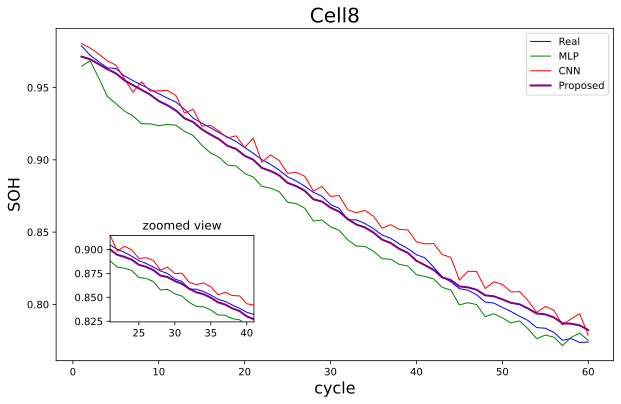

In [47]:
def plot_curves_with_zoom( y_real, y_mlp, y_cnn ,y_proposed,zoom='zoomed view',title='CS2_35 Battery'):
    # 创建主图
    plt.figure(figsize=(10, 6))

    x_real = np.arange(1, len(y_real) + 1)
    # 绘制主图中的四条曲线
    plt.plot(x_real, y_real, label='Real', color='blue', linewidth=1)
    plt.plot(x_real, y_mlp, label='MLP', color='green', linewidth=1)
    plt.plot(x_real, y_cnn, label='CNN', color='red', linewidth=1)
    plt.plot(x_real, y_proposed, label='Proposed', color='purple', linewidth=2)
    
    # 设置主图标题和标签
    plt.title(title,fontsize=20)
    plt.xlabel('cycle',fontsize=16)
    plt.ylabel('SOH',fontsize=16)
    plt.legend(loc='upper right')  # 图例在右上角
    
    # 添加放大图
    ax_inset = plt.axes([0.2, 0.2, 0.2, 0.2])  # 放大图的位置和大小
    ax_inset.plot(x_real, y_real, color='blue', linewidth=1)
    ax_inset.plot(x_real, y_mlp, color='green', linewidth=1)
    ax_inset.plot(x_real, y_cnn, color='red', linewidth=1)
    ax_inset.plot(x_real, y_proposed, color='purple', linewidth=2)
    
    # 设置放大图的显示范围（取中间一小段）
    mid_point = len(x_real) // 2
    zoom_range = 10  # 放大范围
    ax_inset.set_xlim(x_real[mid_point - zoom_range], x_real[mid_point + zoom_range])
    ax_inset.set_ylim(min(y_real[mid_point - zoom_range:mid_point + zoom_range]) - 0.01,
                      max(y_real[mid_point - zoom_range:mid_point + zoom_range]) + 0.01)
    
    # 设置放大图标题
    ax_inset.set_title(zoom)
    
    # 显示图像
    plt.show()

# 示例数据
x = np.linspace(0, 10, 500)
y_real = np.sin(x)
y_mlp = np.sin(x) + 0.1 * np.random.normal(size=len(x))
y_cnn = np.sin(x) + 0.05 * np.random.normal(size=len(x))
y_proposed = np.sin(x) + 0.02 * np.random.normal(size=len(x))

# 调用函数
plot_curves_with_zoom(test_results[1][0],test_results_mlp[1][1], 
                      test_results_conv[1][1],test_results[1][1],title='Cell8')

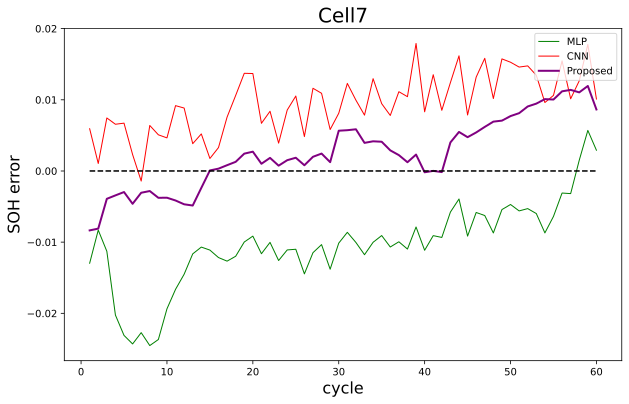

In [51]:
def subtract_lists(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("两个列表的长度必须相同！")
    return [x - y for x, y in zip(list1, list2)]
def plot_difference_curves(y_real, y_mlp, y_cnn, y_proposed,title='C2S'):
    # 生成 x 值（从 1 开始递增）
    # 创建主图
    plt.figure(figsize=(10, 6))

    x_real = np.arange(1, len(y_real) + 1)
    # 绘制主图中的四条曲线
    plt.plot(x_real, y_mlp-y_real, label='MLP', color='green', linewidth=1)
    plt.plot(x_real, y_cnn-y_real, label='CNN', color='red', linewidth=1)
    
    plt.plot(x_real, y_proposed-y_real, label='Proposed', color='purple', linewidth=2)
    plt.plot(x_real,0*y_mlp,color='black',linestyle='--')
    # 设置主图标题和标签
    plt.title(title,fontsize=20)
    plt.xlabel('cycle',fontsize=16)
    plt.ylabel('SOH error',fontsize=16)
    plt.legend(loc='upper right')  # 图例在右上角
    plt.show()
plot_difference_curves(test_results[0][0],test_results_mlp[0][1].reshape(-1), 
                       test_results_conv[0][1].reshape(-1),
                       test_results[0][1].reshape(-1),title='Cell7')